In [23]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging

After scrolling through the images, i realised there are black lines which does not add any value to the images, hence we need to remove those lines from the images.

### Removing black lines

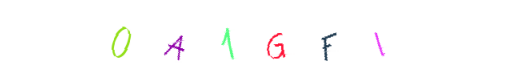

In [6]:
# Load the image
path = 'train/0a1gfi-0.png'
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

def mask_image(image):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([25, 25, 25]) 
    mask = cv2.inRange(image, lower_black, upper_black)

    # image[mask > 0] = [255, 255, 255] 
    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

masked_image = mask_image(image_rgb)
# Display the result
plt.imshow(masked_image)
plt.axis('off')
plt.show()

### Edge Detection

#### Butterworth highpass filter

C:\Users\spooj\AppData\Local\Temp\ipykernel_24272\1533755350.py:8: RuntimeWarning: divide by zero encountered in divide
  filter_mask = 1 / (1 + (cutoff / distance)**(2 * order))


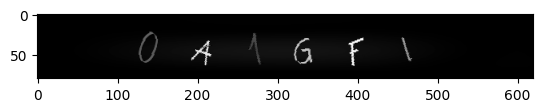

In [20]:
def butterworth_highpass_filter(shape, cutoff, order):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain
    x = np.arange(0, cols)
    y = np.arange(0, rows)
    X, Y = np.meshgrid(x, y)
    distance = np.sqrt((X - ccol)**2 + (Y - crow)**2)
    filter_mask = 1 / (1 + (cutoff / distance)**(2 * order))
    return filter_mask


def apply_filter(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plt.imshow(image, cmap='gray')
    # convert to frequency domain
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform) 
    # apply high-pass filter (edge detection)
    cutoff = 2  
    order = 5   
    filter_mask = butterworth_highpass_filter(image.shape, cutoff, order)
    filtered_f_shift = f_shift * filter_mask
    # trasnform back to spatial domain
    f_ishift = np.fft.ifftshift(filtered_f_shift)
    filtered_image = np.abs(np.fft.ifft2(f_ishift))
    return filtered_image

filtered_image = apply_filter(masked_image).astype(np.uint8)
plt.imshow(filtered_image, cmap='gray')



#### Laplace edge detection

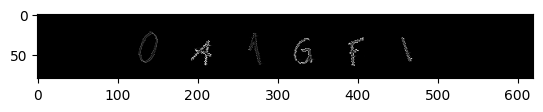

In [10]:
def laplacian_edge_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(image, cv2.CV_8UC1)
    return laplacian
plt.imshow(laplacian_edge_detection(masked_image), cmap='gray')

#### Canny Edge detection

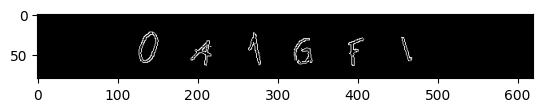

In [11]:
# Canny is specifically designed to detect edges, gussian blur before edge detection
# butterworth removes high freq component (edges get amplified in that process but not the main purpose)
def canny_edge_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(image, (3, 3), 1.5)  
    edges = cv2.Canny(image, 100, 200)  
    return edges
plt.imshow(canny_edge_detection(masked_image), cmap='gray')
canny = canny_edge_detection(masked_image)


#### Sobel Edge detection

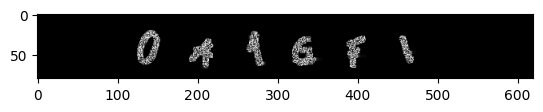

In [12]:
def sobel_edge_detection(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)  
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)  
    # calculate the magnitude of the gradient vector at each pixel - bascially combine both
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    return sobel_magnitude
plt.imshow(sobel_edge_detection(masked_image), cmap='gray')
sobel = sobel_edge_detection(masked_image).astype(np.uint8)
plt.imshow(sobel, cmap='gray')

In [9]:
print(sobel.shape)
print(masked_image.shape)

(80, 385)
(80, 385, 3)


### Segment each image (character wise)

It's hard to segment the characters, initially theres a lot of overlap between the segments so I tried using different herarchies (only those which are the parent), furthermore, I joined rectanges which are overlapping and only accepted rectangles which are bigger than a certain area.

In [ ]:
def find_contours(image, masked_image_gray):
    def has_overlap(curr_rect, exist_rect, threshold=0.5):
        """Check if two rectangles overlap significantly"""
        x1, y1, w1, h1 = curr_rect
        x2, y2, w2, h2 = exist_rect

        w = (x2 + w2) - x1
        y = min(y1, y2)
        h = max(y1 + h1, y2 + h2) - y
        area = w * h

        area_curr = w1 * h1
        area_exist = w2 * h2
        if area / area_exist >= threshold:
            return True, curr_rect if area_curr > area_exist else exist_rect
        return False, None
    
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = [cv2.boundingRect(c) for c in contours]
    rectangles.sort(key=lambda x: x[0])
    filtered_rectangles = []
    
    # find potential overlapping rectangles (horizontal)
    prev_end = None
    for i, rect in enumerate(rectangles):
        curr_start = rect[0]
        # first rectangle
        if not prev_end:
            filtered_rectangles.append(rect)
            prev_end = rect[0] + rect[2]
            continue
        
        # no overlap
        if curr_start < prev_end:
            prev_end = rect[0] + rect[2]
            continue
        else:
            overlap, big_rect = has_overlap(rect, filtered_rectangles[-1])
            if overlap and big_rect == rect:
                    filtered_rectangles.pop()
            filtered_rectangles.append(rect)
            prev_end = rect[0] + rect[2]
            
 


    characters = []
    margin = 2

    for (x, y, w, h) in filtered_rectangles:
        x_start = max(0, x - margin)
        y_start = max(0, y - margin)
        x_end = min(image.shape[1], x + w + margin)
        y_end = min(image.shape[0], y + h + margin)
        
        char_region = masked_image_gray[y_start:y_end, x_start:x_end]
        characters.append(char_region)
        if char_region.shape[0] > 15 and char_region.shape[1] > 15:
            characters.append(char_region)

    return characters
    

characters = find_contours(canny, masked_image)
for i, char in enumerate(characters):
        plt.subplot(1, len(characters), i+1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
        plt.show()

(80, 620)
55 255


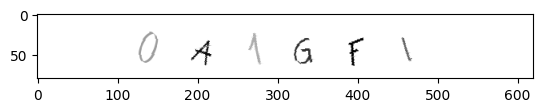

In [22]:
masked_image_gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
plt.imshow(masked_image_gray, cmap='gray')
print(masked_image_gray.shape)
print(np.min(masked_image_gray), np.max(masked_image_gray))

### Pre-process function for the entire dataset

In [ ]:
def apply_filter(image, func):
    filtered_image = func(image).astype(np.uint8)
    canny = canny_edge_detection(image)
    characters = find_contours(filtered_image, image)
    return characters

def overall_size(sobel, canny):
    sobel_count = 0
    canny_count = 0
    for i in range(len(sobel)):
        sobel_img = sobel[i]
        canny_img = canny[i]
        sobel_area = sobel_img.shape[0] * sobel_img.shape[1]
        canny_area = canny_img.shape[0] * canny_img.shape[1]
        if sobel_area < 75:
            sobel_count -= 10
        if canny_area < 75:
            canny_count -= -10
        if sobel_area >= canny_area:
            sobel_count += 1
        else:
            canny_count += 1
    return sobel if sobel_count >= canny_count else canny


def preprocess_segment(image_path, no_of_chars):
    # read the image
    image = cv2.imread(image_path)
    # convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # mask the image
    masked_image = mask_image(image_rgb)
    # masked image to gray scale
    masked_imaged_gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
    # apply filter
    canny_chars = apply_filter(masked_image, canny_edge_detection)
    sobel_chars = apply_filter(masked_image, sobel_edge_detection)
    normal_chars = find_contours(masked_imaged_gray, masked_image)
    all= [normal_chars, canny_chars, sobel_chars]
    matched_len = []
    for chars in all:
        if len(chars) == no_of_chars:
            matched_len.append(chars)
    if len(matched_len) == 0:
        return sobel_chars
    elif len(matched_len) == 1:
        return matched_len[0]
    elif len(matched_len) == 2:
        return overall_size(matched_len[0], matched_len[1])
    else:
        check_1 = overall_size(matched_len[0], matched_len[1])
        check_2 = overall_size(check_1, matched_len[2])
        return check_2



    

In [ ]:
logging.basicConfig(filename='image_processing-test.log', level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s', force=True)

incorrect_segmentation = []
def process_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        image_path = os.path.join(input_dir, filename)
        no_of_chars = len(filename.split('-')[0])
        characters = preprocess_segment(image_path, no_of_chars)
        if no_of_chars != len(characters):
            logging.info(f'Image {filename} has {len(characters)} characters, expected {no_of_chars}')
            incorrect_segmentation.append(filename)
            continue
        # # create a subfolder for each image
        image_name = filename.split('.')[0]
        # image_output_dir = os.path.join(output_dir, image_name)
        # if not os.path.exists(image_output_dir):
        #     os.makedirs(image_output_dir)
        # # save the characters
        # for i, char in enumerate(characters):
        #     char_output_path = os.path.join(image_output_dir, f'{filename[i]}.png')
        #     cv2.imwrite(char_output_path, char)
        
        # enumerate thru the chars create a folder for each char and save the char in that folder
        for i, char in enumerate(characters):
            char_dir = os.path.join(output_dir, image_name[i])
            if not os.path.exists(char_dir):
                os.makedirs(char_dir)
            char_output_path = os.path.join(char_dir, f'{image_name}-{i}.png')
            cv2.imwrite(char_output_path, char)
        
        print(f'Processed {filename} and saved {len(characters)} characters to')
            



            

In [ ]:
process_images('test', 'output-test')

### Exploration with Pre-Trained segmentation model

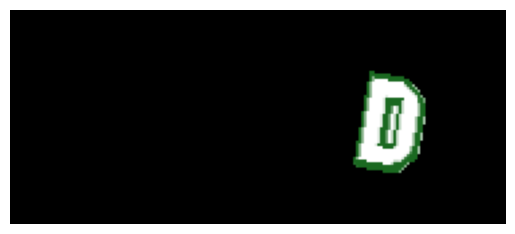

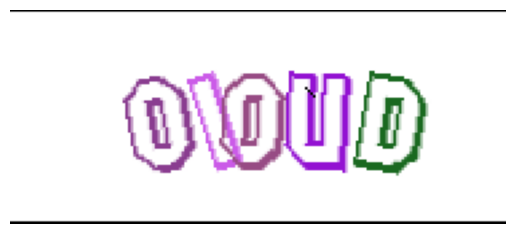

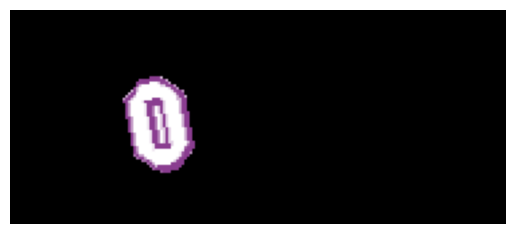

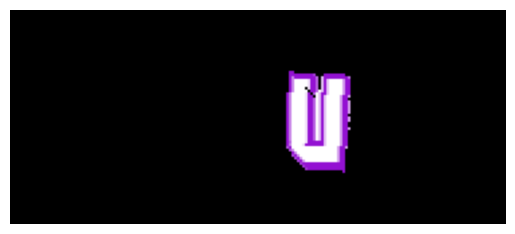

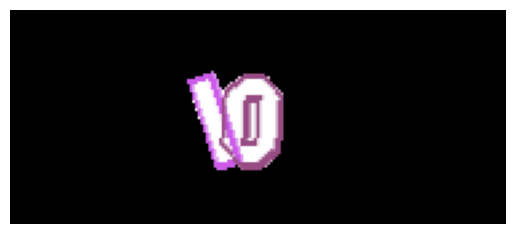

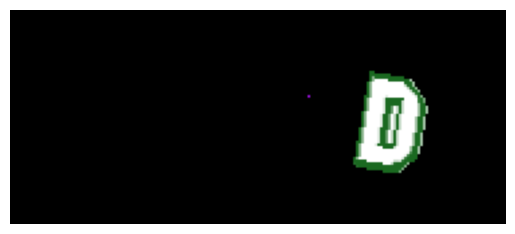

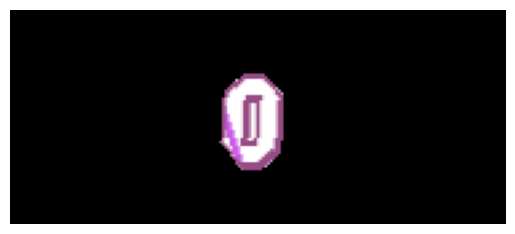

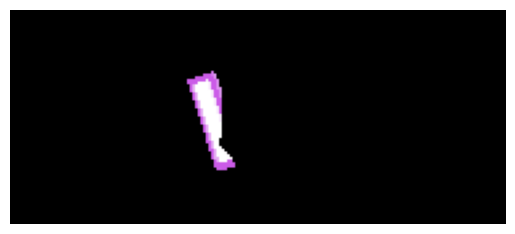

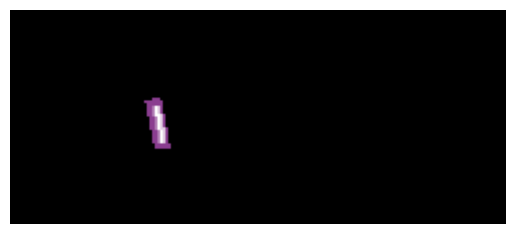

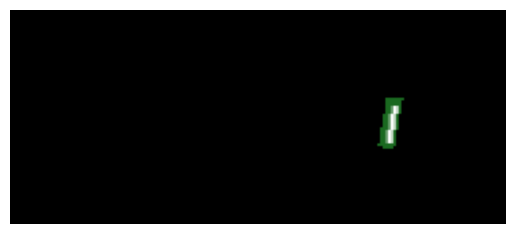

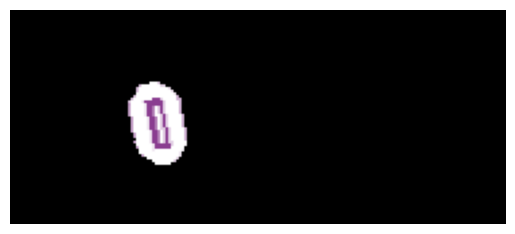

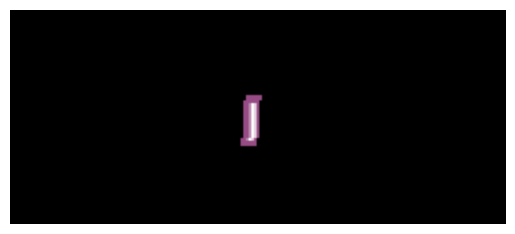

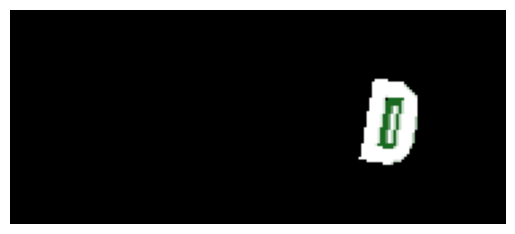

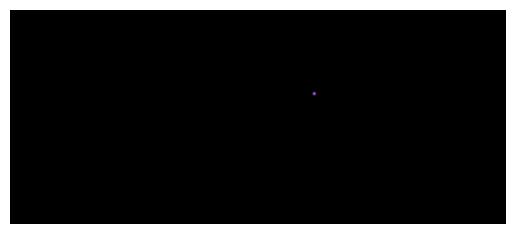

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load and preprocess the image
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the pre-trained SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Initialize the automatic mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks for the entire image
masks = mask_generator.generate(image_rgb)

# Visualize the masks
for mask in masks:
    segmented_image = image_rgb.copy()
    segmented_image[~mask["segmentation"]] = 0  # Apply mask
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.show()


### Finding incorrectly labelled samples after partition

In [24]:
from skimage.feature import hog
import numpy as np
from skimage.transform import resize
import cv2
from sklearn.cluster import DBSCAN
import os

In [ ]:
mis = []
def extract_hog_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        mis.append(image_path)
        return None
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = resize(gray_img, (64, 64), anti_aliasing=True)
    fd, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd



In [ ]:
# Changed the eps and min_samples to get better clusters 
def mislabel(dir):
    all_files = os.listdir(dir)
    feature_vectors = [extract_hog_features(os.path.join(dir, img_path)) for img_path in all_files] 
    feature_arr = np.array(feature_vectors)
    dbscan = DBSCAN(eps=2.3, min_samples=2) 
    labels = dbscan.fit_predict(feature_arr)
    return labels
    

In [ ]:
features_array = [extract_hog_features(os.path.join('output-test', img_path)) for img_path in os.listdir('output-test')]
features_vectors_clean = [f for f in features_array if f is not None]
features_array = np.array(feature_vectors_clean)

dbscan = DBSCAN(eps=2.3, min_samples=3)  
labels = dbscan.fit_predict(features_array)
print(labels == 1)